In [2]:
!pip install scikit-learn


   ---------------------------------------- 0.0/9.3 MB ? eta -:--:--
   ---------- ----------------------------- 2.4/9.3 MB 12.2 MB/s eta 0:00:01
   -------------------- ------------------- 4.7/9.3 MB 11.9 MB/s eta 0:00:01
   ------------------------------- -------- 7.3/9.3 MB 11.9 MB/s eta 0:00:01
   ---------------------------------------- 9.3/9.3 MB 11.5 MB/s eta 0:00:00


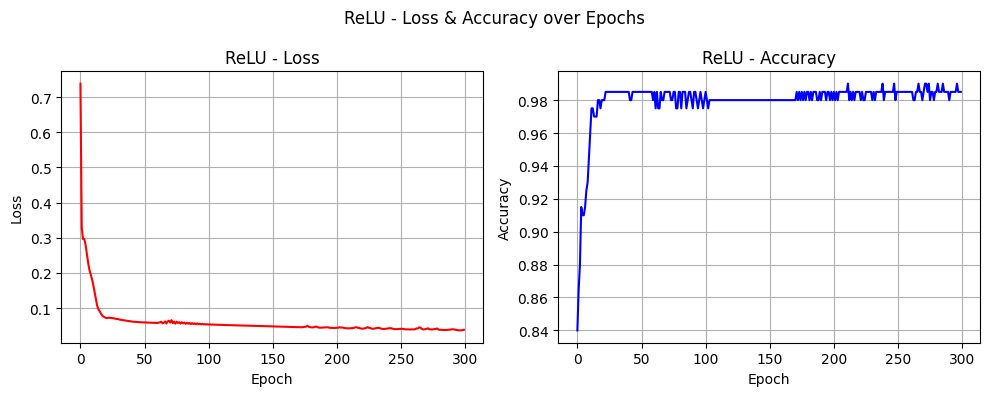

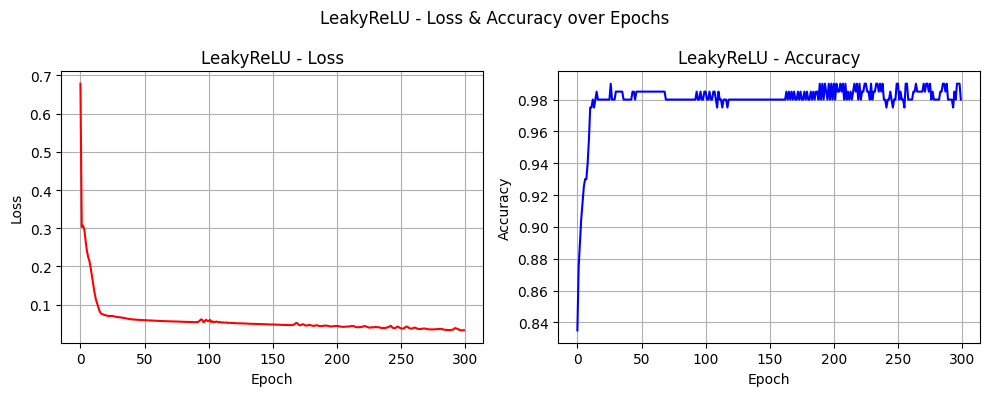

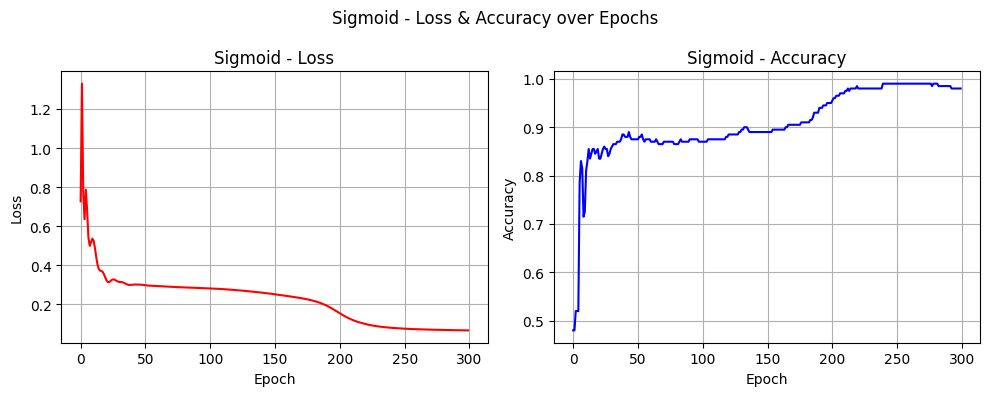

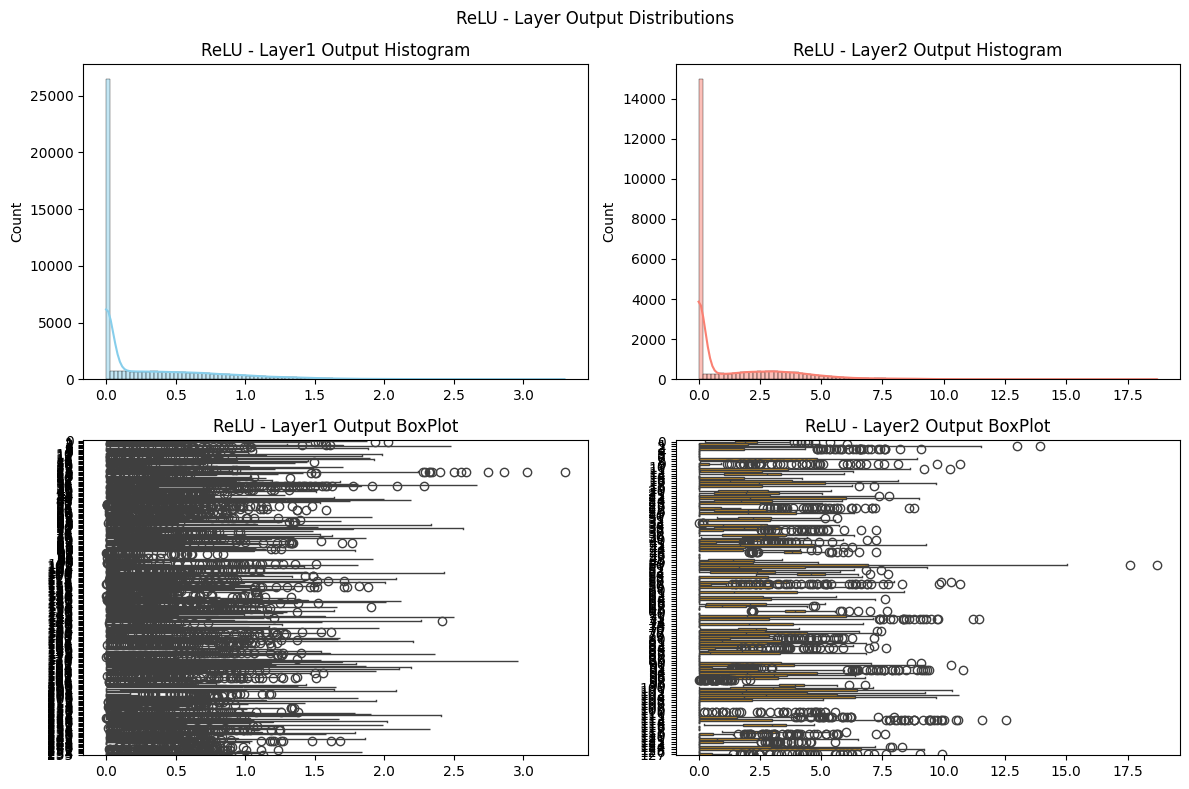

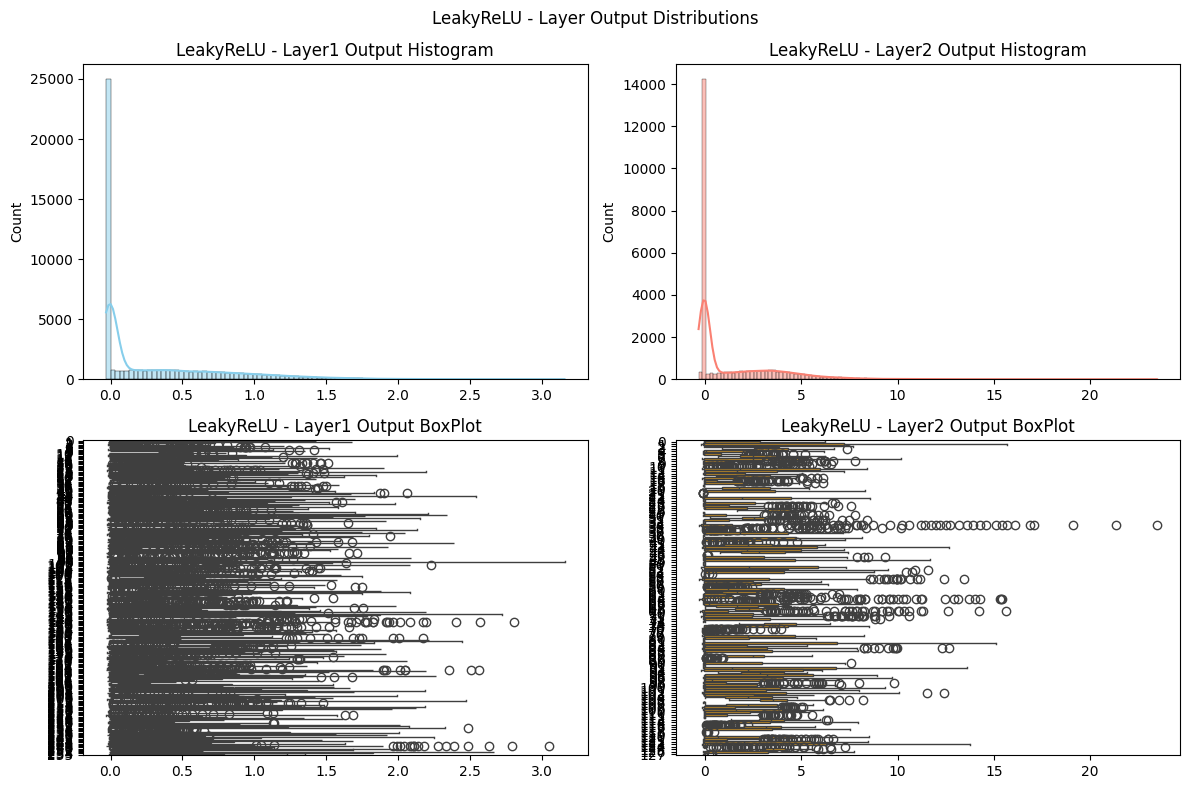

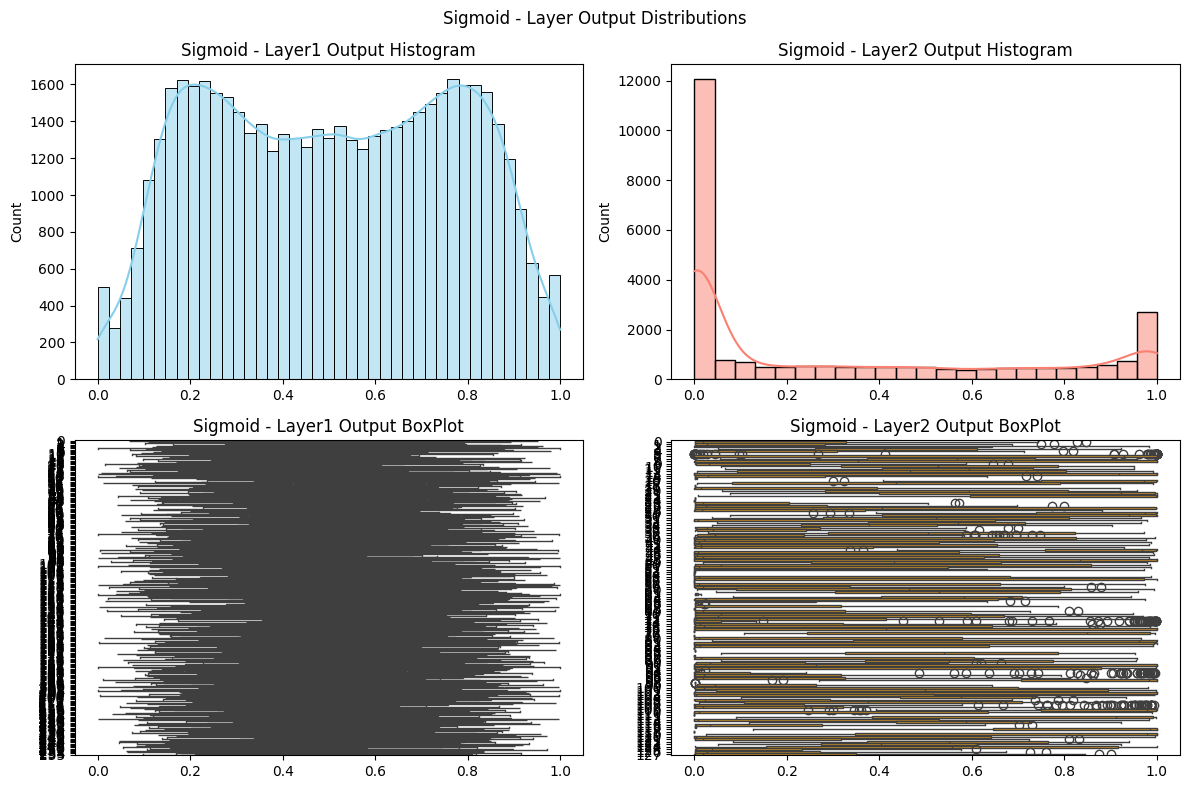

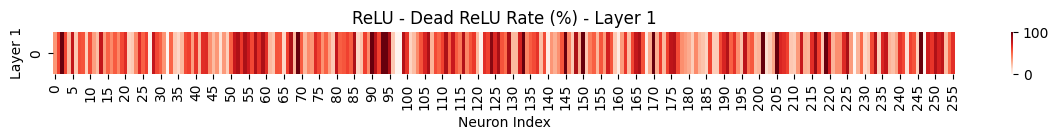

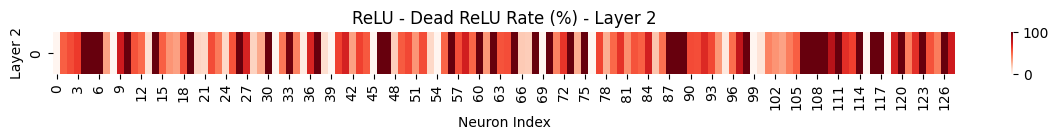

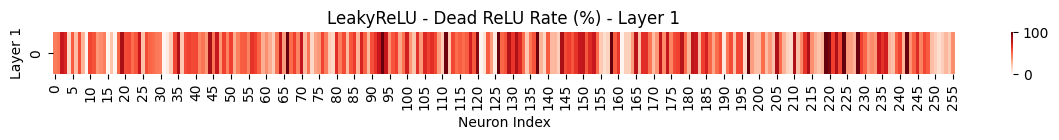

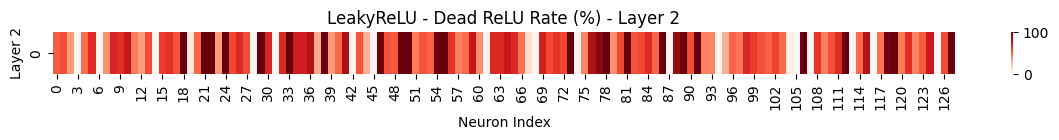

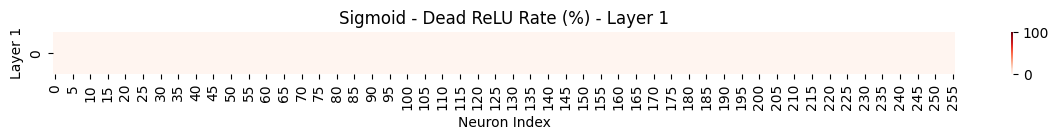

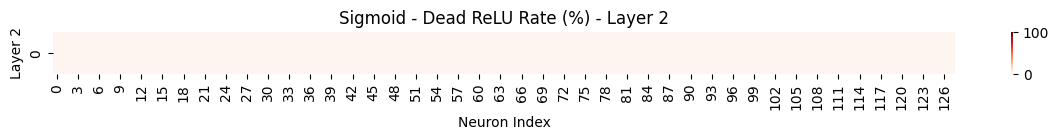

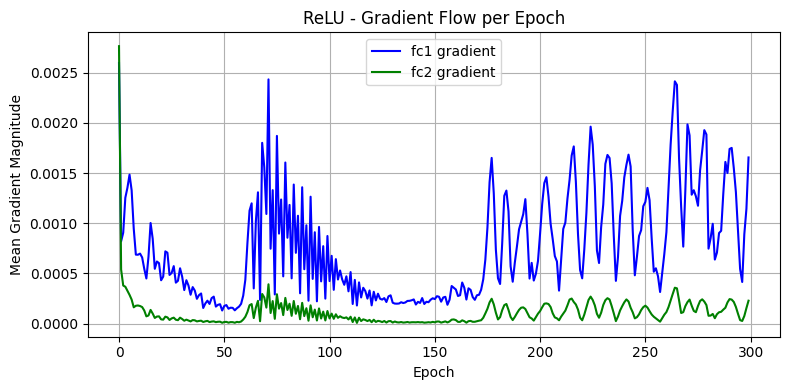

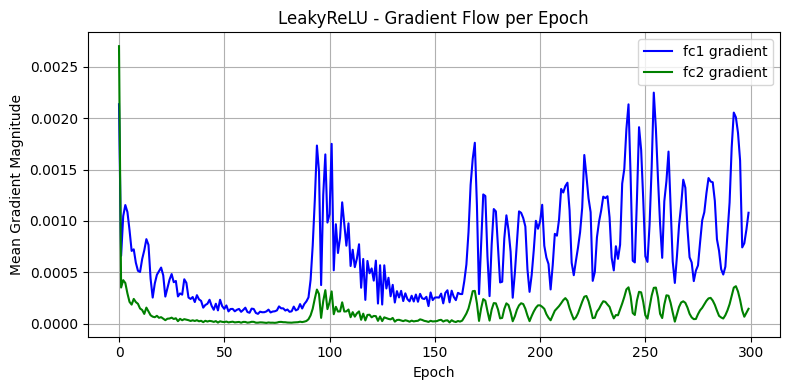

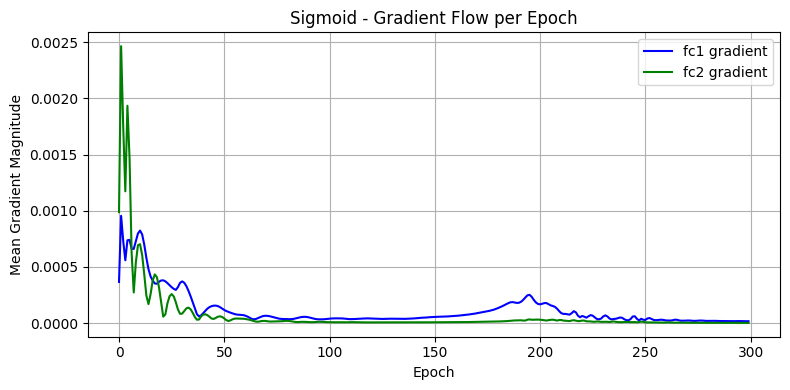


=== 실험 B 정량 비교표 ===
Activation Function  Dead ReLU 비율 (Layer1 %)  Dead ReLU 비율 (Layer2 %)  Final Accuracy (%)  Min Loss  수렴 Epoch
               ReLU                    50.21                    57.50                98.5    0.0367       297
          LeakyReLU                    48.73                    56.52                98.0    0.0325       298
            Sigmoid                     0.00                     0.00                98.0    0.0663       300


In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 1. random seed 설정
torch.manual_seed(42)
np.random.seed(42)

# 2. 데이터셋 
X, y = make_moons(n_samples=1000, noise=0.2)
scaler = StandardScaler()
X = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# 3. 모델 정의
class SimpleMLP(nn.Module):
    def __init__(self, input_size, num_classes, activation_fn):
        super(SimpleMLP, self).__init__()
        self.activation_fn = activation_fn
        self.fc1 = nn.Linear(input_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        out1 = self.activation_fn(self.fc1(x))   # Layer1
        out2 = self.activation_fn(self.fc2(out1))  # Layer2
        out3 = self.fc3(out2)                    # Output
        return out3, out1, out2


# 4. 학습 및 평가 함수
def train_and_evaluate(activation_fn, act_name, lr=0.01, epochs=300):
    model = SimpleMLP(input_size=2, num_classes=2, activation_fn=activation_fn).train()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    losses, accuracy = [], []
    all_outputs_layer1, all_outputs_layer2 = [], []
    grads_fc1, grads_fc2 = [], []

    for epoch in range(epochs):
        optimizer.zero_grad()
        output, out1, out2 = model(X_train)
        loss = loss_fn(output, y_train)
        loss.backward()

        grads_fc1.append(model.fc1.weight.grad.abs().mean().item())
        grads_fc2.append(model.fc2.weight.grad.abs().mean().item())

        optimizer.step()
        losses.append(loss.item())

        with torch.no_grad():
            model.eval()
            pred, out1_eval, out2_eval = model(X_test)
            acc = (pred.argmax(dim=1) == y_test).float().mean().item()
            accuracy.append(acc)
            all_outputs_layer1.append(out1_eval.detach().numpy())
            all_outputs_layer2.append(out2_eval.detach().numpy())
            model.train()

    last_out1 = all_outputs_layer1[-1]
    last_out2 = all_outputs_layer2[-1]
    dead_relu1 = np.mean(last_out1 <= 0) * 100
    dead_relu2 = np.mean(last_out2 <= 0) * 100

    return {
        "model": model,
        "losses": losses,
        "accuracy": accuracy,
        "dead_relu1": dead_relu1,
        "dead_relu2": dead_relu2,
        "layer1_output": last_out1,
        "layer2_output": last_out2,
        "grad_fc1": grads_fc1,
        "grad_fc2": grads_fc2
    }


# 5. 실험
activations = {
    "ReLU": F.relu,
    "LeakyReLU": F.leaky_relu,
    "Sigmoid": torch.sigmoid
}
results = {name: train_and_evaluate(fn, name) for name, fn in activations.items()}

# 6. loss 및 Accuracy 시각화
for name, res in results.items():
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(res["losses"], label="Loss", color='red')
    plt.title(f"{name} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(res["accuracy"], label="Accuracy", color='blue')
    plt.title(f"{name} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.grid(True)

    plt.suptitle(f"{name} - Loss & Accuracy over Epochs")
    plt.tight_layout()
    plt.show()

# 7. 결과 시각화
# 7-1. 중간 레이어 출력 분포 시각화
for name, res in results.items():
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    sns.histplot(res["layer1_output"].flatten(), kde=True, ax=axes[0, 0], color='skyblue')
    axes[0, 0].set_title(f"{name} - Layer1 Output Histogram")

    sns.histplot(res["layer2_output"].flatten(), kde=True, ax=axes[0, 1], color='salmon')
    axes[0, 1].set_title(f"{name} - Layer2 Output Histogram")

    sns.boxplot(data=res["layer1_output"], ax=axes[1, 0], orient="h", color='lightgreen')
    axes[1, 0].set_title(f"{name} - Layer1 Output BoxPlot")

    sns.boxplot(data=res["layer2_output"], ax=axes[1, 1], orient="h", color='orange')
    axes[1, 1].set_title(f"{name} - Layer2 Output BoxPlot")

    plt.suptitle(f"{name} - Layer Output Distributions")
    plt.tight_layout()
    plt.show()

# 7-2. Dead ReLU Heatmap(Layer 1)
for name, res in results.items():
    plt.figure(figsize=(12, 1.5))
    sns.heatmap(
        [(res["layer1_output"] <= 0).mean(axis=0) * 100],
        cmap="Reds", cbar=True, vmin=0, vmax=100
    )
    plt.title(f"{name} - Dead ReLU Rate (%) - Layer 1")
    plt.ylabel("Layer 1")
    plt.xlabel("Neuron Index")
    plt.tight_layout()
    plt.show()

# 7-3. Dead ReLU Heatmap(Layer 2)
    plt.figure(figsize=(12, 1.5))
    sns.heatmap(
        [(res["layer2_output"] <= 0).mean(axis=0) * 100],
        cmap="Reds", cbar=True, vmin=0, vmax=100
    )
    plt.title(f"{name} - Dead ReLU Rate (%) - Layer 2")
    plt.ylabel("Layer 2")
    plt.xlabel("Neuron Index")
    plt.tight_layout()
    plt.show()

# 7-4. Gradient 흐름 
for name, res in results.items():
    plt.figure(figsize=(8, 4))
    plt.plot(res["grad_fc1"], label="fc1 gradient", color="blue")
    plt.plot(res["grad_fc2"], label="fc2 gradient", color="green")
    plt.title(f"{name} - Gradient Flow per Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Mean Gradient Magnitude")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 8. 정량 비교표
comparison_df = pd.DataFrame({
    "Activation Function": list(results.keys()),
    "Dead ReLU 비율 (Layer1 %)": [round(res["dead_relu1"], 2) for res in results.values()],
    "Dead ReLU 비율 (Layer2 %)": [round(res["dead_relu2"], 2) for res in results.values()],
    "Final Accuracy (%)": [round(res["accuracy"][-1]*100, 2) for res in results.values()],
    "Min Loss": [round(min(res["losses"]), 4) for res in results.values()],
    "수렴 Epoch": [np.argmin(res["losses"]) + 1 for res in results.values()]
})
print("\n=== 실험 B 정량 비교표 ===")
print(comparison_df.to_string(index=False))

"""
=== 실험 B 정량 비교표 ===
Activation Function  Dead ReLU 비율 (Layer1 %)  Dead ReLU 비율 (Layer2 %)  Final Accuracy (%)  Min Loss  수렴 Epoch
               ReLU                    50.21                    57.50                98.5    0.0367       297
          LeakyReLU                    48.73                    56.52                98.0    0.0325       298
            Sigmoid                     0.00                     0.00                98.0    0.0663       300
"""